In [180]:
import os
import pandas as pd
import numpy as np
import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'


In [181]:
train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv')
train = pd.read_csv(train_data_path)
test= pd.read_csv(test_data_path)

print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


<AxesSubplot:>

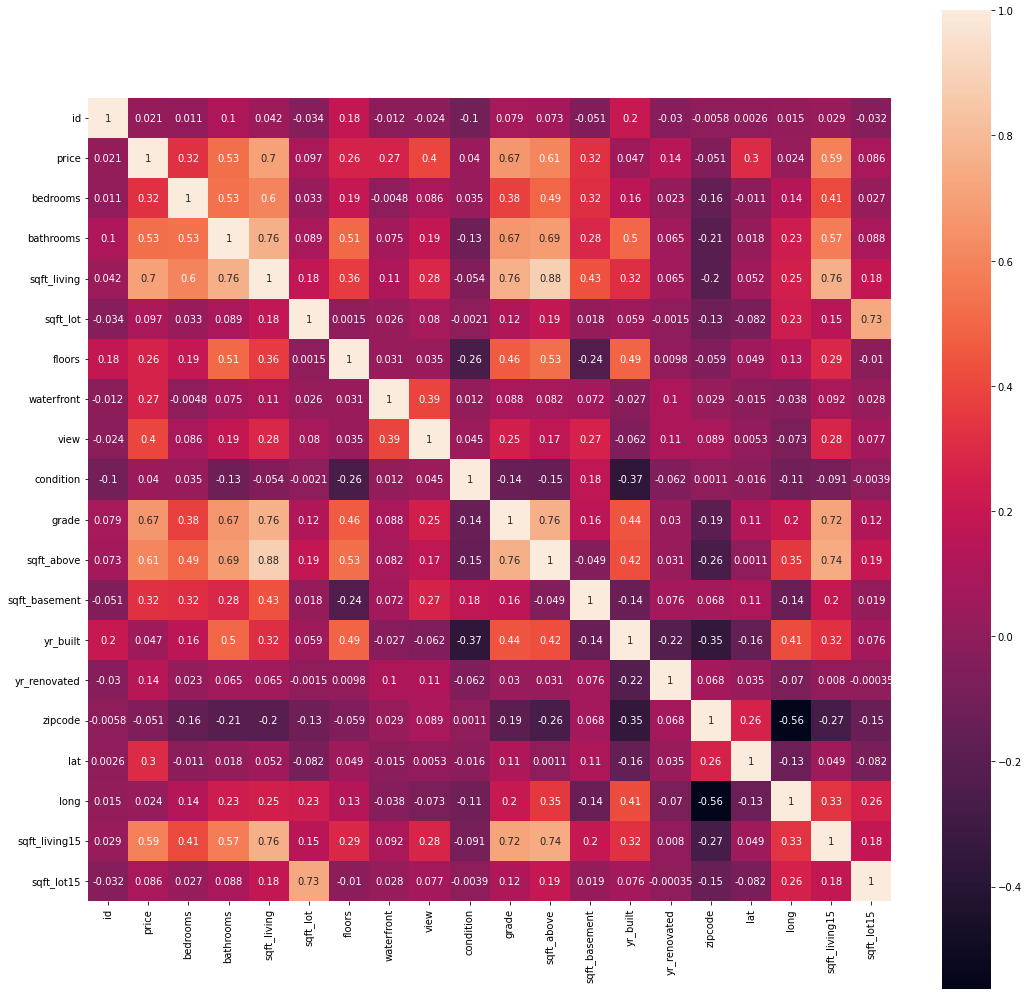

In [182]:
plt.figure(figsize=(18,18))
sns.heatmap(train.corr(),annot=True,square=True)

#### 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?

In [183]:
y = train['price']

del train['price']

In [184]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

In [185]:
data.shape

(21503, 20)

In [186]:
# 결측치 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [187]:
#필요없는 변수값 제거
sub_id = data['id'][train_len:]
del data['id']

In [188]:
#Date 전처리 1
data['date'] = data['date'].apply(lambda x : int(x[:8])).astype(str)

newData= data

In [189]:
newData.shape

(21503, 19)

In [190]:
# #Date 전처리 2
# data['year'] = data['date'].str[0:4]
# data['month'] = data['date'].str[4:6]
# data['day'] = data['date'].str[6:]
# del data['date']
# newData = data

In [191]:
newData.shape

(21503, 19)

In [192]:
print(len(newData[:train_len]),len(y))
view = pd.concat([newData[:train_len], y], axis=1)

15035 15035


<AxesSubplot:>

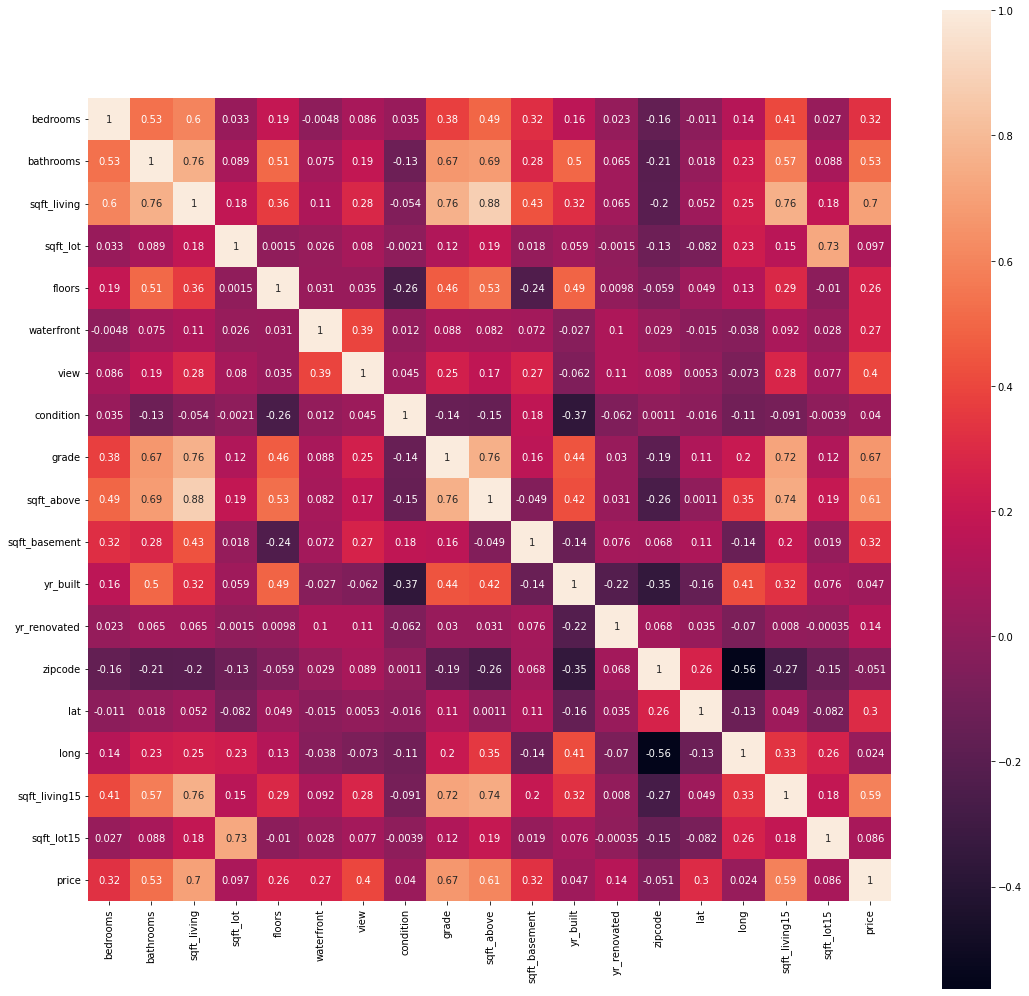

In [193]:
plt.figure(figsize=(18,18))
sns.heatmap(view.corr(),annot=True,square=True)

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


<AxesSubplot:xlabel='price', ylabel='Density'>

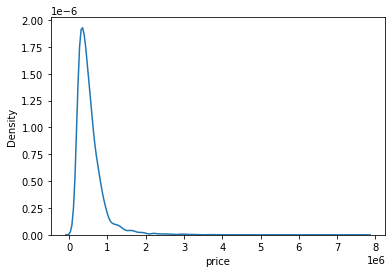

In [139]:
# min max와 표준편차가가 크다
print(y.describe())
sns.kdeplot(data=y)

<AxesSubplot:xlabel='price', ylabel='Density'>

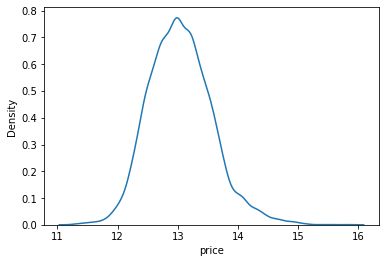

In [140]:
#정규화
y = np.log1p(y)
sns.kdeplot(data=y)

In [152]:
#threshold ( 0.1 ) drop : [sqft_lot, yr_built, zipcode, long, sqft_lot15]
for col in ['sqft_lot', 'yr_built', 'zipcode', 'long', 'sqft_lot15']:
    del newData[col]

In [153]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder

# 1. 카테고리형 변수 (원-핫 인코딩 또는 레이블 인코딩)
newData = pd.get_dummies(newData, columns=['waterfront', 'view', 'condition', 'grade'])



In [154]:
# 2. 연속형 변수 (최소-최대 정규화 또는 표준화)
scaler = MinMaxScaler()
newData[['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15']] = scaler.fit_transform(newData[['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'sqft_living15']])


In [155]:
newData.shape

(21503, 34)

In [157]:
test = newData.iloc[train_len:, :]
xData = newData.iloc[:train_len, :]

In [158]:
newData

,date,bedrooms,bathrooms,sqft_living,floors,sqft_above,sqft_basement,yr_renovated,lat,sqft_living15,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,20141013,0.090909,0.12500,0.067170,0.0,0.097588,0.000000,0,0.571498,0.161934,...,0,0,0,1,0,0,0,0,0,0
1,20150225,0.060606,0.12500,0.036226,0.0,0.052632,0.000000,0,0.936143,0.399415,...,0,0,1,0,0,0,0,0,0,0
2,20150218,0.090909,0.25000,0.104906,0.0,0.152412,0.000000,0,0.741354,0.241094,...,0,0,0,0,1,0,0,0,0,0
3,20140627,0.090909,0.28125,0.107547,0.4,0.156250,0.000000,0,0.247386,0.316469,...,0,0,0,1,0,0,0,0,0,0
4,20150115,0.090909,0.18750,0.058113,0.0,0.084430,0.000000,0,0.407914,0.215281,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,20140626,0.090909,0.21875,0.091321,0.0,0.132675,0.000000,0,0.247065,0.158493,...,0,0,1,0,0,0,0,0,0,0
6464,20150126,0.090909,0.25000,0.090566,0.8,0.131579,0.000000,0,0.665916,0.172260,...,0,0,0,0,1,0,0,0,0,0
6465,20150219,0.090909,0.31250,0.076981,0.4,0.097588,0.026971,0,0.677819,0.160213,...,0,0,0,0,1,0,0,0,0,0
6466,20140623,0.060606,0.09375,0.055094,0.4,0.080044,0.000000,0,0.705324,0.106866,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

random_state=1     

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

In [160]:
models = [gboost, xgboost, lightgbm, rdforest]

In [161]:
df = {}

for model in models:
    model_name = model.__class__.__name__

    X_train, X_test, y_train, y_test = train_test_split(xData, y, test_size=0.2, random_state=321)

    for model in models:
        model_name = model.__class__.__name__

        model.fit(X_train.values, y_train)    
        predictions = model.predict(X_test.values)
        df[model_name] = np.sqrt(mean_squared_error(y_test, predictions))
    
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    

In [163]:
score_df

,RMSE
RandomForestRegressor,0.217348
GradientBoostingRegressor,0.214152
XGBRegressor,0.210160
LGBMRegressor,0.207953


In [164]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)


In [165]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(xData, y, test_size=0.2, random_state=321)

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(X_train.values, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [166]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(X_train.values, y_train)


LGBMRegressor(max_depth=10, random_state=2020)

In [167]:
prediction = model.predict(test.values)
prediction

array([13.22543053, 12.87011037, 14.25583758, ..., 12.94794918,
       12.66391269, 12.88453423])

In [168]:
grid_model.cv_results_

{'mean_fit_time': array([0.48160777, 0.54780545, 0.774332  , 1.16613345]),
 'std_fit_time': array([0.09941105, 0.07510423, 0.15532746, 0.17663418]),
 'mean_score_time': array([0.07460589, 0.04957342, 0.09875436, 0.0797483 ]),
 'std_score_time': array([0.02600836, 0.01666332, 0.00797915, 0.03293754]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0822803 , -0.06187298, -0.04036523, -0.03948503]),
 'split1_test_score': array([-0.07271043, -0.05531986, -0.03714611, -0.0363965 ]),
 'split2_test_score': array([-0.07483558

In [169]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07781914, -0.05886132, -0.03984309, -0.03893767])

In [174]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = os.path.join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [176]:
prediction = np.expm1(prediction)
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.542819e+05
1,15036,3.885231e+05
2,15037,1.553214e+06
3,15038,3.469923e+05
4,15039,3.006213e+05


In [178]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0500')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0500.csv


#### 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?

#### 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

In [179]:
# 144901.43836